In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time

dataset = pd.read_csv('/Users/swagataashwani/Desktop/MachineLearningTemplate/app_behavior/new_appdata10.csv')

In [2]:
#### Data Pre-Processing ####

# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

In [3]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)


In [4]:

## Balancing the Training Set
import random
y_train.value_counts()

pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

In [5]:
# Removing Identifiers
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [7]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [9]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

0.7657557729151961

Test Data Accuracy: 0.7677


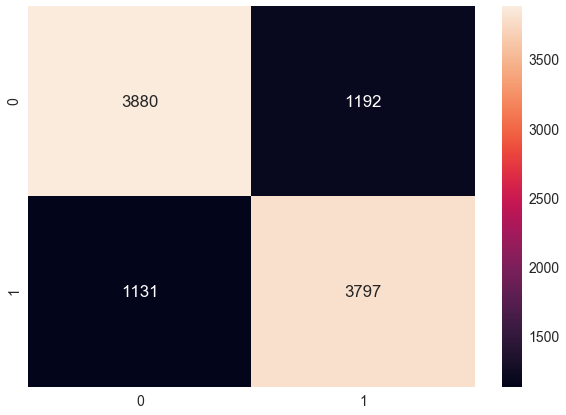

In [10]:

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))


In [11]:

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))



SVM Accuracy: 0.766 (+/- 0.012)


In [12]:

# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)



,features,coef
0,dayofweek,0.033785
1,hour,0.004577
2,age,-0.156461
3,numscreens,-0.100739
4,minigame,-0.025515
5,used_premium_feature,-0.062953
6,liked,0.007489
7,location,-0.040258
8,Institutions,-0.059249
9,VerifyPhone,0.647119


In [ ]:
#### Model Tuning ####

## Grid Search (Round 1)
from sklearn.model_selection import GridSearchCV

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

In [ ]:
## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters
grid_search.best_score_

In [ ]:
# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [ ]:
print(final_results)